In [1]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 32.98 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [2]:
import os
os.chdir('Mask_RCNN')
%tensorflow_version 1.15.3
import tensorflow as tf

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.3`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:
from mrcnn.utils import Dataset
!pip install q keras==2.2.4

     |████████████████████████████████| 317kB 7.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/MyDrive/Colab\ Notebooks/Proyecto/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
annotations		   kangaroo_cfg20210517T2113  requirements.txt
generate_tf_records.py	   kangaroo_cfg20210517T2146  test_images
images			   kangaroo_cfg20210517T2147  test_labels.csv
kangaroo_cfg20210514T0243  kangaroo_cfg20210517T2149  train_labels.csv
kangaroo_cfg20210517T1755  mask_rcnn_coco.h5


In [4]:
from google.colab import drive
import xml.etree.ElementTree as ET

drive.mount('/content/gdrive')
ruta = '/content/gdrive/MyDrive/Colab Notebooks'

tree = ET.parse(ruta + '/Proyecto/annotations/kangaroo-34.xml')

# The root variable allows to access to the xml info with indexes
root = tree.getroot()

Mounted at /content/gdrive


In [5]:
print('the field on xml file ->', root[6][0])
print('the content on that field -> ', root[6][0].text)

the field on xml file -> <Element 'name' at 0x7fd27b675710>
the content on that field ->  kangaroo


## Extract the info contained on the tree obj

In [6]:
img_name = root.find('filename').text
image_width = int(root.find('.//size/width').text)
image_height = int(root.find('.//size/height').text)
bounds = []
for info in root.findall('.//bndbox'):
    x_min = int(info.find('xmin').text)
    y_min = int(info.find('ymin').text)
    x_max = int(info.find('xmax').text)
    y_max = int(info.find('ymax').text)
    bound = [x_min, x_max, y_min, y_max]
    bounds.append(bound)
print('img_name-> ', img_name)
print('image_width-> ', image_width)
print('image_height-> ', image_height)
print('bounds-> ', bounds)
print(len(bounds))

img_name->  kangaroo-34.jpg
image_width->  1200
image_height->  800
bounds->  [[1081, 1198, 318, 645], [984, 1088, 302, 630], [840, 1108, 318, 700], [658, 766, 371, 713], [451, 602, 339, 671], [532, 638, 285, 630], [333, 439, 412, 696], [165, 283, 307, 490], [276, 366, 352, 549]]
9


In [7]:
def get_image_data(image):
    tree_f = ET.parse(ruta + '/Proyecto/annotations/'+ image)
    root_f = tree_f.getroot()
    img_name = root_f.find('filename').text
    image_width = int(root_f.find('.//size/width').text)
    image_height = int(root_f.find('.//size/height').text)
    bounds = []

    for info in root_f.findall('.//bndbox'):
        x_min = int(info.find('xmin').text)
        y_min = int(info.find('ymin').text)
        x_max = int(info.find('xmax').text)
        y_max = int(info.find('ymax').text)
        bound = [x_min, x_max, y_min, y_max]
        bounds.append(bound)
    return(img_name, image_width,image_height, bounds)

In [8]:
print(get_image_data('kangaroo-4.xml'))

('kangaroo-4.jpg', 862, 647, [[286, 795, 81, 503]])


In [9]:
import random
from os import listdir

list_dir = listdir(ruta + '/Proyecto/images')
list_random = random.sample(list_dir, int(len(list_dir)*.2))
print(len(list_random))
print(list_random)

62
['kangaroo-19.jpg', 'kangaroo-553.jpg', 'kangaroo-455.jpg', 'kangaroo-109.jpg', 'kangaroo-361.jpg', 'kangaroo-416.jpg', 'kangaroo-523.jpg', 'kangaroo-428.jpg', 'kangaroo-216.jpg', 'kangaroo-637.jpg', 'kangaroo-6.jpg', 'kangaroo-536.jpg', 'kangaroo-273.jpg', 'kangaroo-519.jpg', 'kangaroo-629.jpg', 'kangaroo-347.jpg', 'kangaroo-688.jpg', 'kangaroo-711.jpg', 'kangaroo-234.jpg', 'kangaroo-107.jpg', 'kangaroo-207.jpg', 'kangaroo-363.jpg', 'kangaroo-701.jpg', 'kangaroo-51.jpg', 'kangaroo-608.jpg', 'kangaroo-318.jpg', 'kangaroo-509.jpg', 'kangaroo-386.jpg', 'kangaroo-251.jpg', 'kangaroo-36.jpg', 'kangaroo-655.jpg', 'kangaroo-24.jpg', 'kangaroo-364.jpg', 'kangaroo-134.jpg', 'kangaroo-153.jpg', 'kangaroo-683.jpg', 'kangaroo-567.jpg', 'kangaroo-245.jpg', 'kangaroo-572.jpg', 'kangaroo-599.jpg', 'kangaroo-504.jpg', 'kangaroo-257.jpg', 'kangaroo-177.jpg', 'kangaroo-114.jpg', 'kangaroo-339.jpg', 'kangaroo-255.jpg', 'kangaroo-489.jpg', 'kangaroo-564.jpg', 'kangaroo-330.jpg', 'kangaroo-274.jpg', 'k

## kangaroo dataset class

In [10]:
import keras_applications
from os import listdir
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot

list_dir = listdir(ruta + '/Proyecto/images')
im_original = list_dir[0]
im_id = list_dir[0][9:-4]
#print(list_dir)
print(int(len(list_dir)*.2))
print(im_original)
print(im_id)

62
kangaroo-106.jpg
106


In [11]:
import random

class KangarooDataset(Dataset):

    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train = True):
        # define one class
        self.add_class("dataset", 1, "kangaroo")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annotations/'
        # separate the test and train data
        list_train, list_test = self.get_training_and_test_separate_lists()
        # find all images
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            # skip test images for train
            if not is_train and self.is_file_contained_in_the_list(filename, list_train):
                continue
            # skip train images for test
            if is_train and self.is_file_contained_in_the_list(filename, list_test):
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
    
    def get_image_data(self, path):
        tree_f = ET.parse(path)
        root_f = tree_f.getroot()
        img_name = root_f.find('filename').text
        image_width = int(root_f.find('.//size/width').text)
        image_height = int(root_f.find('.//size/height').text)
        bounds = []

        for info in root_f.findall('.//bndbox'):
            x_min = int(info.find('xmin').text)
            y_min = int(info.find('ymin').text)
            x_max = int(info.find('xmax').text)
            y_max = int(info.find('ymax').text)
            bound = [x_min, x_max, y_min, y_max]
            bounds.append(bound)
        return(bounds, image_width, image_height)
    
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.get_image_data(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)])
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            y_min, y_max = box[2], box[3]
            x_min, x_max = box[0], box[1]
            masks[y_min:y_max, x_min:x_max, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
    
    def get_training_and_test_separate_lists(self):
        list_dir = listdir(ruta + '/Proyecto/images')
        # these will be the input_lists:
        list_test_r = random.sample(list_dir, int(len(list_dir)*.2))
        list_train_r = []
        for name in list_dir:
            flag = True
            for test in list_test_r:
                if name == test:
                    flag = False
            if flag:
                list_train_r.append(name)

        return list_train_r, list_test_r
    
    def is_file_contained_in_the_list(self, file, input_list):
        is_present = False
        for element in input_list:
            if file == element:
                is_present = True
        return is_present

In [12]:
path = ruta + '/Proyecto'
# train set
train_set = KangarooDataset()
train_set.load_dataset(path, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = KangarooDataset()
test_set.load_dataset(path, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 251
Test: 62


{'id': 'kangaroo-198', 'source': 'dataset', 'path': '/content/gdrive/MyDrive/Colab Notebooks/Proyecto/images/kangaroo-198.jpg', 'annotation': '/content/gdrive/MyDrive/Colab Notebooks/Proyecto/annotations/kangaroo-198.xml'}
(1250, 1000, 3)
class_ids ->  [1]
1


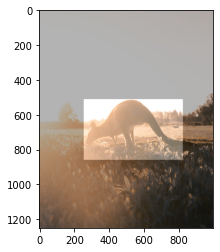

In [13]:
# load an image
image_id = 13
print(test_set.image_info[image_id])
image = test_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = test_set.load_mask(image_id)
print('class_ids -> ', class_ids)
print(mask.shape[2])
# plot image
pyplot.imshow(image)
# plot masks
for i in range(mask.shape[2]):
    pyplot.imshow(mask[:, :, i], cmap='gray', alpha=0.3)

pyplot.show()

{'id': 'kangaroo-127', 'source': 'dataset', 'path': '/content/gdrive/MyDrive/Colab Notebooks/Proyecto/images/kangaroo-127.jpg', 'annotation': '/content/gdrive/MyDrive/Colab Notebooks/Proyecto/annotations/kangaroo-127.xml'}
(600, 1440, 3)
class_ids ->  [1 1]
2


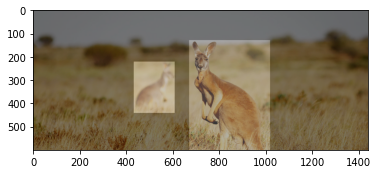

In [14]:
# load an image
image_id = 19
print(train_set.image_info[image_id])
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print('class_ids -> ', class_ids)
print(mask.shape[2])
# plot image
pyplot.imshow(image)
# plot masks
for i in range(mask.shape[2]):
    pyplot.imshow(mask[:, :, i], cmap='gray', alpha=0.3)

pyplot.show()

In [19]:
from mrcnn.config import Config
# define a configuration for the model
class KangarooConfig(Config):
    # define the name of the configuration
    NAME = "kangaroo_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 131

In [16]:
from mrcnn.model import MaskRCNN
# prepare config
config = KangarooConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', config=config, model_dir=path + '/')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Using TensorFlow backend.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
model.load_weights(path + '/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
!pip install keras==2.1.5 --force-reinstall --no-deps --no-cache-dir

     |████████████████████████████████| 337kB 27.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/MyDrive/Colab Notebooks/Proyecto/kangaroo_cfg20210517T2151/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4 

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/10
130/131 [============================>.] - ETA: 1s - loss: 0.9327 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2288 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.3355 - mrcnn_mask_loss: 0.3341

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


131/131 [==============================] - 215s 2s/step - loss: 0.9288 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.2286 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.3336 - mrcnn_mask_loss: 0.3325 - val_loss: 0.6824 - val_rpn_class_loss: 0.0070 - val_rpn_bbox_loss: 0.2072 - val_mrcnn_class_loss: 0.0274 - val_mrcnn_bbox_loss: 0.2115 - val_mrcnn_mask_loss: 0.2293

Epoch 2/10
131/131 [==============================] - 180s 1s/step - loss: 0.6268 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1956 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1774 - mrcnn_mask_loss: 0.2200 - val_loss: 0.5890 - val_rpn_class_loss: 0.0070 - val_rpn_bbox_loss: 0.1743 - val_mrcnn_class_loss: 0.0383 - val_mrcnn_bbox_loss: 0.1656 - val_mrcnn_mask_loss: 0.2037
Epoch 3/10
131/131 [==============================] - 179s 1s/step - loss: 0.5079 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1614 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.1946 - val_loss: 0.5002 - val_rpn_class_loss: 0.006

# Test model in new images

In [20]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list, scores):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for i in range(len(boxes_list)):
      if scores[i] > 0.97:
        # get coordinates
        y1, x1, y2, x2 = boxes_list[i]
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
     # show the plot
     pyplot.show()
 
# define the test configuration
class TestConfig(Config):
     NAME = "kangaroo"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 1

In [33]:
# define the model
rcnn = MaskRCNN(mode='inference', model_dir= path + '/', config=TestConfig())
# load kangaroo model weights
rcnn.load_weights(path + '/kangaroo_cfg20210517T2151/mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)

Re-starting from epoch 5


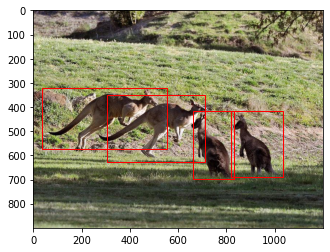

[0.9966409  0.9954609  0.98773426 0.98235184 0.797004  ]
[1 1 1 1 1]


In [30]:
image = path + '/test_images/kangaroo-197.jpg'
img = load_img(image)
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)[0]
# visualize the results
draw_image_with_boxes(image, results['rois'], results['scores'])
print(results['scores'])
print(results['class_ids'])

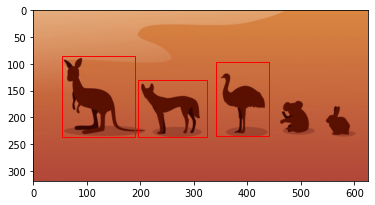

[0.99624485 0.9953655  0.9800944  0.95521224 0.886483  ]
[1 1 1 1 1]


In [31]:
image = path + '/test_images/animals4.jpg'
img = load_img(image)
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)[0]
# visualize the results
draw_image_with_boxes(image, results['rois'], results['scores'])
print(results['scores'])
print(results['class_ids'])